In [3]:




import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import json
import re
import yaml
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import random

os.environ["CUDA_VISIBLE_DEVICES"] = "7"
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']  # 设置字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
cmap = LinearSegmentedColormap.from_list("prob_cmap", ["red", "yellow", "green"])
# nltk.data.path.append('/home/nfs03/laizj/model/nltk_data')

In [4]:
results_path = "/home/nfs02/laizj/experiment/uncertainty_analysis/analysis_unknown/results/gsm8k-train-disturbed_inference_0.7_0.75_5.json"
source_path = "/home/nfs02/laizj/experiment/uncertainty_analysis/analysis_unknown/results/gsm8k-train-disturbed_inference_0.7_0.75_5.json"
model_path = "/home/nfs05/laizj/model/models--kevinpro--MistralMathOctopus-7B/snapshots/de76d14562b1da1ba0e52d5b245cf9c0859e2af3"
model_path = "/home/nfs05/laizj/model/models--Qwen--Qwen2.5-Math-7B/snapshots/b101308fe89651ea5ce025f25317fea6fc07e96e"

In [ ]:

correct_data = []
half_data = []
wrong_data = []
less_than_one_count = 0

def extract_last_num(text: str) -> float:
    text = re.sub(r"(\d),(\d)", r"\g<1>\g<2>", text)  # 处理形如 123,456
    res = re.findall(r"(\d+(\.\d+)?)", text)  # 匹配 123456.789
    if len(res) > 0:
        num_str = res[-1][0]
        return float(num_str)
    else:
        return 0.0
    
def certain_shuffle(arr):
    if len(arr) <= 1: return arr
    idx1, idx2 = random.sample(range(len(arr)), 2)
    arr[idx1], arr[idx2] = arr[idx2], arr[idx1]

    remaining_indices = [i for i in range(len(arr)) if i not in {idx1, idx2}]
    remaining_elements = [arr[i] for i in remaining_indices]
    random.shuffle(remaining_elements)
    
    for i, val in zip(remaining_indices, remaining_elements):
        arr[i] = val
    
    return arr
    
def shuffle_str_last_ratio(sentence: str, language: str, ratio = None):
    raw_sentences = []
    init_sentences = sent_tokenize(sentence, language)
    for sent in init_sentences:
        raw_sentences += sent.split('\n')
    
    last_sent = raw_sentences[-1:]
    raw_sentences = raw_sentences[:-1]
    ordered_sentence_wo_ans, ordered_sentence =  "\n".join(raw_sentences), "\n".join(raw_sentences + last_sent)
    
    if ratio is not None:
        if len(raw_sentences) >= 5:
            first_sentences_num = int(len(raw_sentences) * (1 - ratio))
            first_sentences = raw_sentences[:first_sentences_num]
            sentences = raw_sentences[first_sentences_num:]
            sentences = certain_shuffle(sentences)
            sentences = first_sentences + sentences
            return {
                "ordered_sentence_wo_ans": ordered_sentence_wo_ans,
                "ordered_sentence": ordered_sentence,
                "shuffle_sentence_wo_ans": "\n".join(sentences), 
                "shuffle_sentence": "\n".join(sentences + last_sent)
                }, False
        else:
            return {}, True
    else:
        if len(raw_sentences) * 0.33 >= 2:
            shuffle_sentence_wo_ans_group = []
            shuffle_sentence_group = []
            for ratio in np.arange(0, 1, 0.33):
                first_sentences_num =  int(len(raw_sentences) * (1 - ratio))
                first_sentences = raw_sentences[:first_sentences_num]
                sentences = raw_sentences[first_sentences_num:]
                sentences = certain_shuffle(sentences)
                sentences = first_sentences + sentences
                shuffle_sentence_wo_ans_group.append("\n".join(sentences))
                shuffle_sentence_group.append("\n".join(sentences + last_sent))
            return {
                "ordered_sentence_wo_ans": ordered_sentence_wo_ans,
                "ordered_sentence": ordered_sentence,
                "shuffle_sentence_wo_ans_group": shuffle_sentence_wo_ans_group, 
                "shuffle_sentence_group": shuffle_sentence_group
                }, False
        else:
            return {}, True

def shuffle_str_first_ratio(sentence: str, language: str, ratio = None):
    raw_sentences = []
    init_sentences = sent_tokenize(sentence, language)
    for sent in init_sentences:
        raw_sentences += sent.split('\n')
    
    last_sent = raw_sentences[-1:]
    raw_sentences = raw_sentences[:-1]
    ordered_sentence_wo_ans, ordered_sentence =  "\n".join(raw_sentences), "\n".join(raw_sentences + last_sent)
    if ratio is not None:
        if len(raw_sentences) >= 2:
            first_sentences_num = int(len(raw_sentences) * ratio)
            sentences = raw_sentences[:first_sentences_num]
            last_sentences = raw_sentences[first_sentences_num:]
            sentences = certain_shuffle(sentences)
            sentences += last_sentences
            return {
                "ordered_sentence_wo_ans": ordered_sentence_wo_ans,
                "ordered_sentence": ordered_sentence,
                "shuffle_sentence_wo_ans": "\n".join(sentences), 
                "shuffle_sentence": "\n".join(sentences + last_sent)
                }, False
        else:
            return {}, True
    else:
        if len(raw_sentences) * 0.33 >= 2:
            shuffle_sentence_wo_ans_group = []
            shuffle_sentence_group = []
            for ratio in np.arange(0, 1, 0.33):
                first_sentences_num = len(raw_sentences) - int(len(raw_sentences) * (1 - ratio))
                sentences = raw_sentences[:first_sentences_num]
                last_sentences = raw_sentences[first_sentences_num:]
                sentences = certain_shuffle(sentences)
                # sentences += last_sentences
                # shuffle_sentence_wo_ans_group.append("\n".join(sentences))
                # shuffle_sentence_group.append("\n".join(sentences + last_sent))
                
                last_sentences += last_sent
                shuffle_sentence_wo_ans_group.append("\n".join(sentences))
                shuffle_sentence_group.append("\n".join(sentences + last_sentences[:1]))
                
            return {
                "ordered_sentence_wo_ans": ordered_sentence_wo_ans,
                "ordered_sentence": ordered_sentence,
                "shuffle_sentence_wo_ans_group": shuffle_sentence_wo_ans_group, 
                "shuffle_sentence_group": shuffle_sentence_group
                }, False
        else:
            return {}, True

source = None
results = None
with open(source_path, 'r') as src_f, open(results_path, 'r') as f:
    source = json.load(src_f)
    results = json.load(f)
    source = results
    
for i in range(len(source)):
    count = 0
    # results[i]['language'] = re.search(r'Please answer in \b(.+?)\b', results[i]['prompt']).group(1).lower()
    # if results[i]['language'] != 'english': continue
    results[i]['correct_generated_texts'] = []
    results[i]['wrong_generated_texts'] = []
    
    results[i]['chosen'], flag = shuffle_str_first_ratio(source[i]['chosen'], results[i]['language'], 1)
    less_than_one_count += flag
    if flag: continue
    
    for generated_text in results[i]["generated_texts"]:
        if abs(extract_last_num(text=source[i]["chosen"]['ordered_sentence']) - extract_last_num(generated_text)) < 1e-2:
            count += 1
            results[i]['correct_generated_texts'].append(generated_text)
        else:
            results[i]['wrong_generated_texts'].append(generated_text) 
    
    if count == 0:
        wrong_data.append(results[i])
    elif count == len(results[i]["generated_texts"]):
        correct_data.append(results[i])
    else:
        half_data.append(results[i])

print(f"{len(source)}=")
print(f"{less_than_one_count=}")
print(len(correct_data))
print(len(half_data))
print(len(wrong_data))

KeyError: 'chosen'

In [5]:
pattern = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\。|\!|\！|\?|\？|\…|\n|\r|\t)\s*(?![0-9])'

# for dataset in [correct_data, half_data, wrong_data]:
#     for item in dataset:
#         sentences = re.split(pattern, item['chosen'])
#         random.shuffle(sentences)


In [6]:
correct_data[3]['chosen']['shuffle_sentence_group'], correct_data[3]['chosen']['shuffle_sentence_wo_ans_group']

NameError: name 'correct_data' is not defined

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map='auto')
        

Loading checkpoint shards: 100%|██████████| 6/6 [01:00<00:00, 10.00s/it]


In [37]:
def calculate_results_ppl(text_wo_ans, text):
    inputs_wo_ans = tokenizer(text_wo_ans, return_tensors="pt")["input_ids"].to(model.device)
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    len_inputs_wo_ans = inputs_wo_ans.shape[1]
    additional_input_ids = inputs["input_ids"][:, len_inputs_wo_ans:]
    
    outputs = model(**inputs)
    logits = outputs.logits
    
    shift_logits = logits[:, len_inputs_wo_ans - 1:-1, :]  # 对齐 logits 和 labels
    shift_labels = additional_input_ids  # 多出来的部分的真实 token IDs
    loss = F.cross_entropy(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))
    additional_ppl = torch.exp(loss).item()
    return additional_ppl


model.eval()
results = []

# ppls = []
ppl = []

with torch.no_grad():
    for dataset in [correct_data]:
    # for dataset in [wrong_data]:
        # ppl = []
        for i in trange(min(500, len(dataset))):
            # ordered_ppl = calculate_results_ppl(
            #     dataset[i]['prompt'] + dataset[i]['chosen']["ordered_sentence_wo_ans"],
            #     dataset[i]['prompt'] + dataset[i]['chosen']['ordered_sentence'],
            # )
            # shuffle_ppl = calculate_results_ppl(
            #     dataset[i]['prompt'] + dataset[i]['chosen']["shuffle_sentence_wo_ans"],
            #     dataset[i]['prompt'] + dataset[i]['chosen']['shuffle_sentence'],
            # )
            
            # ppl.append((ordered_ppl, shuffle_ppl))
            
            
            for j in range(len( dataset[i]['chosen']['shuffle_sentence_wo_ans_group'])):
                shuffle_ppl = calculate_results_ppl(
                    dataset[i]['prompt'] + dataset[i]['chosen']["shuffle_sentence_wo_ans_group"][j],
                    dataset[i]['prompt'] + dataset[i]['chosen']['shuffle_sentence_group'][j],
                )
            
                ppl.append(shuffle_ppl)
            
            # outputs = model(**inputs, output_hidden_states=True)
            # results.append({
            #     'prompt': dataset[i]['prompt'],
            #     'answer': dataset[i]['answer'],
            #     'generated_text': dataset[i]['prompt'] + dataset[i]['wrong_generated_texts'][3],
            #     'outputs': outputs, 
            #     })
            # inputs = tokenizer(dataset[i]['prompt'] + dataset[i]['wrong_generated_texts'][1], return_tensors="pt").to(model.device)
            # outputs = model(**inputs, output_hidden_states=True)
            # results.append({
            #     'prompt': dataset[i]['prompt'],
            #     'answer': dataset[i]['answer'],
            #     'generated_text': dataset[i]['prompt'] + dataset[i]['wrong_generated_texts'][1],
            #     'outputs': outputs, 
            #     })
        # ppls.append(ppl)

100%|██████████| 304/304 [04:50<00:00,  1.05it/s]


In [ ]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sat Mar  8 19:13:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:01:00.0 Off |                  Off |
| 47%   73C    P2            284W /  300W |   42303MiB /  49140MiB |     96%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

: 

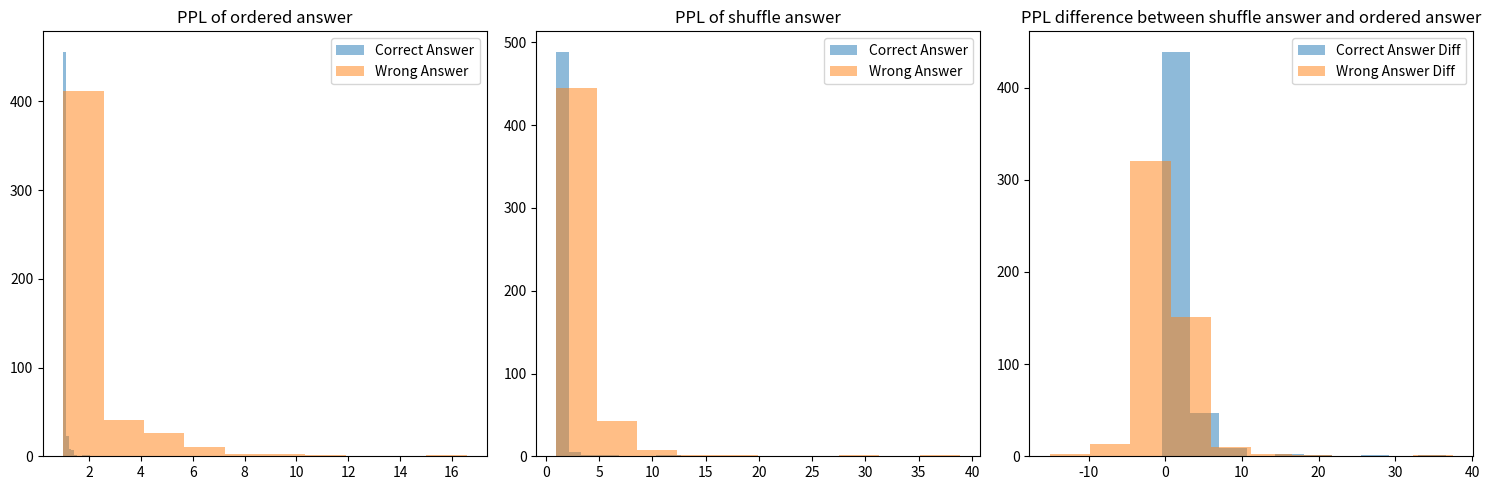

In [18]:
data1 = np.array(ppls[0])
data2 = np.array(ppls[2])
# 提取第一个元素和第二个元素
data1_first = data1[:, 0]
data1_second = data1[:, 1]

data2_first = data2[:, 0]
data2_second = data2[:, 1]

# 绘制第一个数据的直方图
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(data1_first, bins=10, alpha=0.5, label='Correct Answer')
plt.hist(data1_second, bins=10, alpha=0.5, label='Wrong Answer')
plt.title('PPL of ordered answer')
plt.legend()

# 绘制第二个数据的直方图
plt.subplot(1, 3, 2)
plt.hist(data2_first, bins=10, alpha=0.5, label='Correct Answer')
plt.hist(data2_second, bins=10, alpha=0.5, label='Wrong Answer')
plt.title('PPL of shuffle answer')
plt.legend()

# 绘制第二个数据减去第一个数据的直方图
diff_first = (data2_second - data1_first) / data1_first
diff_second = (data2_second - data1_second) / data2_first

plt.subplot(1, 3, 3)
plt.hist(diff_first, bins=10, alpha=0.5, label='Correct Answer Diff')
plt.hist(diff_second, bins=10, alpha=0.5, label='Wrong Answer Diff')
plt.title('PPL difference between shuffle answer and ordered answer')
plt.legend()

plt.tight_layout()
plt.savefig("/home/nfs02/laizj/experiment/uncertainty_analysis/analysis_unknown/results/ppl.png")

In [19]:
diff_first.mean(), diff_second.mean()

(1.4815750532778824, 0.42176870196043664)

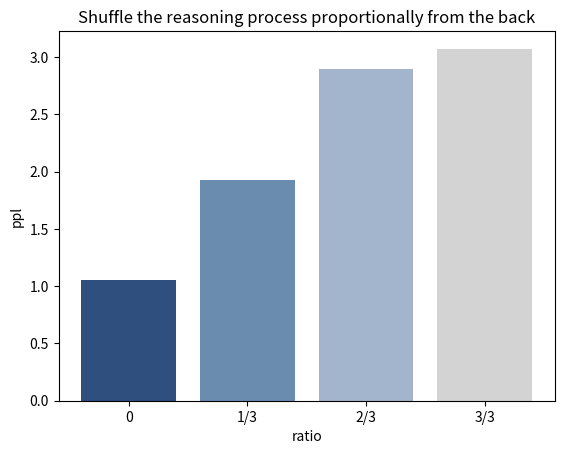

In [ ]:
data = np.array(ppl).reshape(-1, 4).mean(axis=0)

# 定义x轴的标签
labels = ['0', '1/3', '2/3', '3/3']

# 绘制柱状图
plt.bar(labels, data, color=['#2F4F7F', '#6A8DAF', '#A2B5CD', '#D3D3D3'])
plt.xlabel('ratio')
plt.ylabel('ppl')
# plt.title('Shuffle the reasoning process proportionally from the back')
plt.title('Shuffle the reasoning process proportionally from the front')
plt.show()

In [34]:
def merge_tokens_2_word(tokens, token_probs):
    merged = []
    merged_probs = []
    
    current_chars = []   # 当前累积的字符
    current_probs = []   # 当前累积的概率
    current_bytes = []   # 当前累积的字节
    current_bytes_probs = []  # 字节标记对应的概率

    def decode_bytes():
        """处理字节标记的合并"""
        nonlocal current_bytes, current_bytes_probs
        if not current_bytes:
            return
        
        try:
            # 解码字节序列
            decoded = b''.join(current_bytes).decode('utf-8')
            if current_chars:
                # 处理已有字符
                merged.append(''.join(current_chars))
                merged_probs.append(current_probs.copy())
                current_chars.clear()
                current_probs.clear()
            merged.append(decoded)
            merged_probs.append(current_bytes_probs.copy())
        except UnicodeDecodeError:
            # 解码失败时保留原始标记
            merged.extend([f'<0x{b.hex()}>' for b in current_bytes])
            merged_probs.extend([[p] for p in current_bytes_probs])
        
        current_bytes.clear()
        current_bytes_probs.clear()

    for token, prob in zip(tokens, token_probs):
        # 匹配字节标记 <0xXX>
        byte_match = re.match(r'^<0x([0-9A-Fa-f]+)>$', token)
        if byte_match:
            # 累积字节和概率
            current_bytes.append(bytes.fromhex(byte_match.group(1)))
            current_bytes_probs.append(prob)
        else:
            # 遇到非字节标记先处理已累积的字节
            decode_bytes()

            # 处理特殊前缀 ▁
            if token == '▁':
                if current_chars:
                    # 提交当前累积的词
                    merged.append(''.join(current_chars))
                    merged_probs.append(current_probs.copy())
                    current_chars.clear()
                    current_probs.clear()
                current_chars.append(token)
                current_probs.append(prob)
            else:
                current_chars.append(token)
                current_probs.append(prob)
    
    # 处理最后剩余的标记
    decode_bytes()
    if current_chars:
        merged.append(''.join(current_chars))
        merged_probs.append(current_probs)

    return merged, merged_probs

In [52]:

def analysis_per_sample(data, fix_prob=0.3):
    prompt_ids = tokenizer(data['prompt'], return_tensors="pt")['input_ids'][0]
    input_ids = tokenizer(data['generated_text'], return_tensors="pt")['input_ids'][0][prompt_ids.size(-1):]

    logits = data['outputs'].logits[0, prompt_ids.size(-1) - 1: -1, :].cpu()
    probs = F.softmax(logits, dim=-1)

    token_probs = probs.gather(dim=-1, index=input_ids.unsqueeze(-1)).squeeze(-1)

    tokens = tokenizer.convert_ids_to_tokens(input_ids.tolist())
    # tokens, token_probs = merge_tokens_2_word(tokens, token_probs)
    # print(tokens)
    

    # filtered_tokens = []
    # filtered_probs = []
    # for token, prob in zip(tokens, token_probs):
    #     if prob < fix_prob: 
    #         filtered_tokens.append(token)
    #         filtered_probs.append(prob.item())

    # print(filtered_tokens)

    # # 绘制图表
    # plt.figure(figsize=(12, 6))
    # plt.bar(range(len(filtered_tokens)), filtered_probs, tick_label=filtered_tokens)
    # plt.xlabel('Tokens')
    # plt.ylabel('Probability')
    # plt.title(f'Token Generation Probabilities (Prob < {fix_prob})')
    # # plt.xticks(rotation=90)
    # plt.tight_layout()
    # plt.show()
    
    colored_text = ""
    for token, prob in zip(tokens, token_probs):
        prob_value = torch.tensor(prob).min().item()  # 取最大概率
        # 将概率映射到颜色
        color = cmap(prob_value)  # 获取颜色
        color_hex = '#%02x%02x%02x' % (int(color[0]*255), int(color[1]*255), int(color[2]*255))  # 转换为十六进制
        # 将token和颜色添加到文本中
        colored_text += f'<span style="color: {color_hex};">{token}</span> '
    
    # 打印带颜色的文本
    from IPython.display import display, HTML
    display(HTML(colored_text))


In [80]:
print(results[0]['generated_text'])

analysis_per_sample(results[0], fix_prob=0.8)

Below is an instruction that describes a task. Write a response that appropriately completes the request in Chinese. Please answer in Chinese.

### Instruction:
卡拉正在下载一个 200 GB 的文件。正常情况下，她每分钟可以下载 2 GB，但在下载了 40% 的时候，Windows 强制重新启动以安装更新，而这个过程需要 20 分钟。然后卡拉不得不从头重新下载。下载这份文件需要多长时间？

### Response:在 Windows 强制重新启动之前，卡拉已经下载了 200 GB * 0.4 = <<200*0.4=80>>80 GB。
由于卡拉每分钟下载 2 GB，她需要 80 GB / 2 GB/分钟 = <<80/2=40>>40 分钟才能下载完剩下的 80 GB。
由于卡拉需要重新下载 200 GB - 80 GB = <<200-80=120>>120 GB，她需要 120 GB / 2 GB/分钟 = <<120/2=60>>60 分钟来下载完这份文件。
总共，卡拉需要 40 分钟 + 20 分钟 + 60 分钟 = <<40+20+60=120>>120 分钟来下载这份文件。


/tmp/ipykernel_3845738/3522055613.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob_value = torch.tensor(prob).min().item()  # 取最大概率


In [76]:
print(results[1]['generated_text'])

analysis_per_sample(results[1], fix_prob=0.8)

Below is an instruction that describes a task. Write a response that appropriately completes the request in Chinese. Please answer in Chinese.

### Instruction:
杰瑞正在摇一颗六面骰子。他摇出一个大于 3 的数字的可能性比连续摇出两个偶数的可能性大多少（以百分比表达）？

### Response:首先，我们需要确定杰瑞摇出一个大于 3 的数字的概率。骰子有 6 面，所以有 3 面是大于 3 的数字。因此，杰瑞摇出一个大于 3 的数字的概率是 3/6 = 1/2 = 50%。
接下来，我们需要确定杰瑞连续摇出两个偶数的概率。骰子有 6 面，所以有 3 面是偶数。因此，杰瑞摇出一个偶数的概率是 3/6 = 1/2 = 50%。
由于杰瑞连续摇出两个偶数的概率是 50% * 50% = 25%，所以杰瑞摇出一个大于 3 的数字的概率比连续摇出两个偶数的概率大 50% - 25% = 25%。


/tmp/ipykernel_3845738/3522055613.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob_value = torch.tensor(prob).min().item()  # 取最大概率


In [46]:
inputs = tokenizer(correct_data[0]['generated_texts'], return_tensors="pt")
source = tokenizer(correct_data[0]['prompt'], return_tensors="pt")

In [48]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'][0, source['input_ids'].size(-1)].item())
tokenizer.convert_ids_to_tokens(inputs['input_ids'][0, :source['input_ids'].size(-1)])

['<s>',
 '▁Below',
 '▁is',
 '▁an',
 '▁instruction',
 '▁that',
 '▁describes',
 '▁a',
 '▁task',
 '.',
 '▁Write',
 '▁a',
 '▁response',
 '▁that',
 '▁appropri',
 'ately',
 '▁complet',
 'es',
 '▁the',
 '▁request',
 '▁in',
 '▁Sw',
 'ah',
 'ili',
 '.',
 '▁Please',
 '▁answer',
 '▁in',
 '▁Sw',
 'ah',
 'ili',
 '.',
 '<0x0A>',
 '<0x0A>',
 '###',
 '▁Inst',
 'ruction',
 ':',
 '<0x0A>',
 'J',
 'ill',
 '▁anal',
 'ip',
 'wa',
 '▁$',
 '2',
 '0',
 '▁k',
 'ila',
 '▁sa',
 'a',
 '▁k',
 'uf',
 'un',
 'za',
 '▁na',
 '▁$',
 '3',
 '0',
 '▁k',
 'u',
 'wa',
 '▁k',
 'och',
 'a',
 '▁wa',
 '▁m',
 'ash',
 'ab',
 'iki',
 '.',
 '▁I',
 'w',
 'ap',
 'o',
 '▁h',
 'u',
 'wa',
 '▁an',
 'af',
 'anya',
 '▁k',
 'azi',
 '▁w',
 'iki',
 '▁',
 '5',
 '0',
 '▁k',
 'wa',
 '▁m',
 'w',
 'aka',
 ',',
 '▁sa',
 'a',
 '▁',
 '3',
 '5',
 '▁k',
 'wa',
 '▁w',
 'iki',
 '▁k',
 'ama',
 '▁m',
 'wal',
 'im',
 'u',
 '▁na',
 '▁sa',
 'a',
 '▁',
 '1',
 '5',
 '▁k',
 'ama',
 '▁k',
 'och',
 'a',
 ',',
 '▁m',
 'sh',
 'ah',
 'ara',
 '▁wake',
 '▁wa',
 '▁k',
